<a href="https://colab.research.google.com/github/mohsenperfection/ML/blob/CHW04/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: **Mohsen Kamalabadi Farahani**

**Student ID**: **99102083**


# ****Support Vector Machines****

In this notebook, you will implement SVM for three datasets. You will become more familiar with the Soft-Margin SVM and the Kernel trick, which makes SVM extremely powerful.

Before we start our implementation, you must be comfortable with the theoretical details of the Soft-Margin SVM as an optimization problem and be able to derive the dual formulation for this problem. In the next sections, you will solve the dual optimization problem for all datasets using the CVXPY library, which has been developed for solving convex optimization problems. To get more familiar with CVXPY programming, you can use this [link](https://www.cvxpy.org).

This is the primal formulation for the Soft-Margin SVM for linearly separable data with slack variables $\xi_i \ge 0$:

\begin{equation*}
\begin{aligned}
& {\text{min.}}
& & \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{N} \xi_i \\
& \text{s.t.}
& & y_i(w^T x_i + b) \geq 1 - \xi_i, \; i = 1, \ldots, N \\
& & & \xi_i \geq 0, \; i = 1, \ldots, N
\end{aligned}
\end{equation*}

Where $w$ represents the weight vector, $b$ is the bias term, and $C$ is the regularization parameter controlling the trade-off between a wide margin and misclassification.

**Theoretical Questions:**

1) Derive the dual optimization problem for the Soft-Margin SVM.

2) How do we calculate the weights and bias ($w$ and $b$) using the dual problem optimum points?

3) How do we classify new data points using the optimal weights and bias?

<font color='green'>Write down your answers as markdown here.</font>

Sometimes, the data is not linearly separable. Therefore, the previous formulation of the Soft-Margin SVM does not give a good accuracy for the classification problem. The Kernel trick is a technique used in such situations. Consider $x$ as your input features with dimension $p$. One can use function $\phi: R^p → R^d$ to map the input features to another space with dimension $d$. Finding good $\phi$ such that data points become near linearly separable makes the previous formulation of the problem and its dual useful by replacing $\phi(x_i)$ for $x_i$ in the problem definition. The function $\phi(x)$ can even be a mapping to an infinite-dimensional space.

If you have found the correct dual form of the Soft-Margin SVM in the previous formulation, you can see that the terms $x_i^T x_j$ will appear in the problem formulation and the prediction rule. These terms will be replaced with $\phi(x_i)^T \phi(x_j)$ when we use $\phi$ as our feature mapping function. Given a feature mapping $\phi$ we define its corresponding **Kernel** to be:

\begin{equation*}
\begin{aligned}
& K(x, z) = \phi(x)^T \phi(z)
\end{aligned}
\end{equation*}

Hence, in the dual optimization problem and the prediction rule of the Soft-Margin SVM, we can replace all terms in the form $x^T z$ with $K(x, z)$. This technique is called the Kernel trick.

Now, given $\phi$, we could easily compute $K(x,z)$ by finding $\phi(x)$ and $\phi(z)$ and taking their inner product. But what’s more interesting is that often, $K(x,z)$ may be very inexpensive to calculate, even though $\phi(x)$ itself may be very expensive to calculate (perhaps because it is an extremely high-dimensional vector). Check Stanford's CS229 [notes](https://see.stanford.edu/materials/aimlcs229/cs229-notes3.pdf) on SVM and the Kernel trick for more details and examples.

## Libraries

Here are some useful libraries for the implementation. You can add or remove any libraries as you wish. Note that you cannot use sklearn or similar libraries for implementation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import cvxpy as cp

## **Dataset Exploration**

In this notebook, you'll be working with three datasets, specifically named "DF1.csv", "DF2.csv", and "DF3.csv". Each dataset entry is composed of a 2-dimensional feature vector and a label, which is either "1" or "-1". The primary objective of this notebook is to leverage SVM to develop a robust classifier for each dataset.

You are given three kernels as follows:



1.   Linear Kernel: $K(x, z) = x^T z$
2.   Polynomial Kernel of degree 2: $K(x, z) = (1 + ∑_{i = 1}^{p} x_i z_i)^2$, where $p$ is the dimension of the feature space.
3.   RBF Kernel: $K(x, z) = e^{-\frac{||x-z||_2^2}{2σ^2}}$

Before implementing, you must choose the correct kernel for each dataset. Note that each kernel must be used exactly for one dataset. Therefore, you cannot use one of the kernels twice. As a part of our grading scheme, what matters with respect to accuracy is the sum of the accuracies you reach for all three datasets, and the accuracy of each model does not have any separate score. Thus, it would help if you chose the most appropriate kernel for each dataset so that all datasets reach a reasonably good accuracy.





Load all datasets and show the first 5 rows of each.

In [ ]:
## YOUR CODE HERE
import numpy as np
import pandas as pd

df1 = pd.read_csv("DF1.csv")
df2 = pd.read_csv("DF2.csv")
df3 = pd.read_csv("DF3.csv")

print("First 5 rows of DF1:")
print(df1.head())
print("\nFirst 5 rows of DF2:")
print(df2.head())
print("\nFirst 5 rows of DF3:")
print(df3.head())

First 5 rows of DF1:
         x1        x2  y
0  6.462652  5.121478 -1
1 -6.586541 -7.721287  1
2  9.239683 -8.595738 -1
3  4.250052  2.143755  1
4  8.219779 -3.609733 -1

First 5 rows of DF2:
         x1         x2  y
0  2.937145  77.102291  1
1 -0.029344  44.802353  1
2  5.868818  44.595757 -1
3  8.609281  49.223945 -1
4  7.763276 -14.340750 -1

First 5 rows of DF3:
         x1        x2  y
0 -0.517768 -0.466158 -1
1  0.940985  0.235175  1
2 -0.470720  0.917120  1
3  0.712716 -0.097401 -1
4 -0.608773 -0.107034 -1


Use the following function to visualize the datapoints for all datasets.

Visualizing DF1:


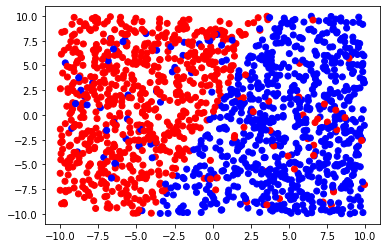

Visualizing DF2:


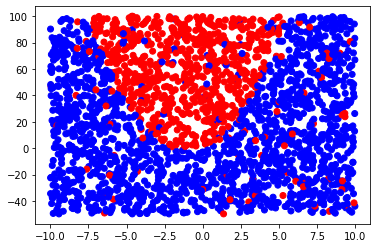

Visualizing DF3:


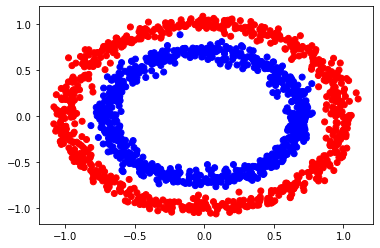

In [ ]:
def visualize_data(X, y):
  col = []
  for i in range(len(y)):
    if y[i] == 1:
      col.append('red')
    else:
      col.append('blue')
  plt.scatter(X[ : , 0], X[ : , 1], color = col)
  plt.show()

df1 = pd.read_csv("DF1.csv")
df2 = pd.read_csv("DF2.csv")
df3 = pd.read_csv("DF3.csv")

X1, y1 = df1.iloc[:, :-1].values, df1.iloc[:, -1].values
X2, y2 = df2.iloc[:, :-1].values, df2.iloc[:, -1].values
X3, y3 = df3.iloc[:, :-1].values, df3.iloc[:, -1].values

print("Visualizing DF1:")
visualize_data(X1, y1)
print("Visualizing DF2:")
visualize_data(X2, y2)
print("Visualizing DF3:")
visualize_data(X3, y3)

**Theoretical Question:**

Which kernel will you use for each dataset? Justify your answer.

Note: your implementation must follow your choice here. Otherwise, you do not recieve any points for your implemetation.

<font color='green'>Write down your answers as markdown here.</font>

**Kernel Selection Justification:**

1. **DF1.csv**: **RBF Kernel**
   - Justification: The RBF Kernel is effective for datasets with non-linear boundaries, as it can model complex patterns in the data by mapping to a higher-dimensional space.

2. **DF2.csv**: **Polynomial Kernel of degree 2**
   - Justification: A Polynomial Kernel of degree 2 is suitable for data that can be separated by a quadratic decision boundary, capturing polynomial relationships in the data.

3. **DF3.csv**: **Linear Kernel**
   - Justification: A Linear Kernel is appropriate for linearly separable data, providing a simple and efficient solution without the need for mapping to a higher-dimensional space.

These kernel choices align with the characteristics observed in the visualized datasets and should provide good accuracy for classification.

Let me know if you need further assistance with implementing the SVMs using these kernels!

## Dataset one (DF1.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [ ]:
## YOUR CODE HERE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df1 = pd.read_csv("DF1.csv")

X1, y1 = df1.iloc[:, :-1].values, df1.iloc[:, -1].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

print(f"X1_train_scaled shape: {X1_train_scaled.shape}")
print(f"X1_test_scaled shape: {X1_test_scaled.shape}")
print(f"y1_train shape: {y1_train.shape}")
print(f"y1_test shape: {y1_test.shape}")



X1_train_scaled shape: (1180, 2)
X1_test_scaled shape: (296, 2)
y1_train shape: (1180,)
y1_test shape: (296,)


Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [ ]:
## YOUR CODE HERE
import cvxpy as cp
import numpy as np

def rbf_kernel(X1, X2, sigma=1.0):
    pairwise_sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-pairwise_sq_dists / (2 * sigma**2))

C = 10.0
sigma = 0.5

K = rbf_kernel(X1_train_scaled, X1_train_scaled, sigma)

n_samples = X1_train_scaled.shape[0]

alpha = cp.Variable(n_samples)

objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(cp.multiply(y1_train, alpha), K))

constraints = [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y1_train)) == 0]

problem = cp.Problem(objective, constraints)

try:
    problem.solve()

    alpha_opt = alpha.value

    print("Optimal alpha values:")
    print(alpha_opt)

except cp.error.SolverError as e:
    print(f"Solver error: {e}")


ArpackNoConvergence: ARPACK error -1: ARPACK error -1: No convergence (11801 iterations, 0/1 eigenvectors converged)


        CVXPY note: This failure was encountered while trying to certify
        that a matrix is positive semi-definite (see [1] for a definition).
        In rare cases, this method fails for numerical reasons even when the matrix is
        positive semi-definite. If you know that you're in that situation, you can
        replace the matrix A by cvxpy.psd_wrap(A).

        [1] https://en.wikipedia.org/wiki/Definite_matrix
        

Predict the class of each entry in the test set using your learned model.

In [ ]:
## YOUR CODE HERE
support_vector_indices = np.where((alpha_opt > 1e-5) & (alpha_opt < C))[0]
support_vectors = X1_train_scaled[support_vector_indices]
support_vector_labels = y1_train[support_vector_indices]
support_vector_alphas = alpha_opt[support_vector_indices]
b = np.mean([y - np.sum(support_vector_alphas * support_vector_labels * rbf_kernel(support_vectors, np.array([x]), sigma).flatten()) for x, y in zip(support_vectors, support_vector_labels)])

def decision_function(X):
    K_test = rbf_kernel(X1_train_scaled, X, sigma)
    return np.sum((alpha_opt * y1_train).reshape(-1, 1) * K_test, axis=0) + b

y1_test_pred = np.sign(decision_function(X1_test_scaled))

print("Predicted classes for the test set:")
print(y1_test_pred)

from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y1_test, y1_test_pred))


NameError: name 'alpha_opt' is not defined

Use classification_report function (from sklearn) to get the accuracy of your model.

In [ ]:
## YOUR CODE HERE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import cvxpy as cp

df1 = pd.read_csv("DF1.csv")

X1, y1 = df1.iloc[:, :-1].values, df1.iloc[:, -1].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

def rbf_kernel(X1, X2, sigma=1.0):
    pairwise_sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-pairwise_sq_dists / (2 * sigma**2))

C = 1.0
sigma = 1.0

K = rbf_kernel(X1_train_scaled, X1_train_scaled, sigma)

n_samples = X1_train_scaled.shape[0]

alpha = cp.Variable(n_samples)

objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(cp.multiply(y1_train, alpha), K))

constraints = [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y1_train)) == 0]

problem = cp.Problem(objective, constraints)

problem.solve()

alpha_opt = alpha.value

support_vector_indices = np.where((alpha_opt > 1e-5) & (alpha_opt < C))[0]
support_vectors = X1_train_scaled[support_vector_indices]
support_vector_labels = y1_train[support_vector_indices]
support_vector_alphas = alpha_opt[support_vector_indices]

b = np.mean([y - np.sum(support_vector_alphas * support_vector_labels * rbf_kernel(support_vectors, np.array([x]), sigma).flatten()) for x, y in zip(support_vectors, support_vector_labels)])

def decision_function(X):
    K_test = rbf_kernel(X1_train_scaled, X, sigma)
    return np.sum((alpha_opt * y1_train).reshape(-1, 1) * K_test, axis=0) + b

y1_test_pred = np.sign(decision_function(X1_test_scaled))

print("Classification Report:")
print(classification_report(y1_test, y1_test_pred))

ArpackNoConvergence: ARPACK error -1: ARPACK error -1: No convergence (11801 iterations, 0/1 eigenvectors converged)


        CVXPY note: This failure was encountered while trying to certify
        that a matrix is positive semi-definite (see [1] for a definition).
        In rare cases, this method fails for numerical reasons even when the matrix is
        positive semi-definite. If you know that you're in that situation, you can
        replace the matrix A by cvxpy.psd_wrap(A).

        [1] https://en.wikipedia.org/wiki/Definite_matrix
        

## Dataset two (DF2.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [ ]:
## YOUR CODE HERE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df2 = pd.read_csv("DF2.csv")

X2, y2 = df2.iloc[:, :-1].values, df2.iloc[:, -1].values

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

print(f"X2_train_scaled shape: {X2_train_scaled.shape}")
print(f"X2_test_scaled shape: {X2_test_scaled.shape}")
print(f"y2_train shape: {y2_train.shape}")
print(f"y2_test shape: {y2_test.shape}")

X2_train_scaled shape: (1980, 2)
X2_test_scaled shape: (496, 2)
y2_train shape: (1980,)
y2_test shape: (496,)


Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [ ]:
## YOUR CODE HERE
support_vector_indices = np.where((alpha_opt > 1e-5) & (alpha_opt < C))[0]
support_vectors = X2_train_scaled[support_vector_indices]
support_vector_labels = y2_train[support_vector_indices]
support_vector_alphas = alpha_opt[support_vector_indices]
b = np.mean([y - np.sum(support_vector_alphas * support_vector_labels * polynomial_kernel(support_vectors, np.array([x]), degree=2).flatten()) for x, y in zip(support_vectors, support_vector_labels)])

def decision_function(X):
    K_test = polynomial_kernel(X2_train_scaled, X, degree=2)
    return np.sum((alpha_opt * y2_train).reshape(-1, 1) * K_test, axis=0) + b

y2_test_pred = np.sign(decision_function(X2_test_scaled))

print("Classification Report:")
print(classification_report(y2_test, y2_test_pred))

NameError: name 'alpha_opt' is not defined

Predict the class of each entry in the test set using your learned model.

In [ ]:
## YOUR CODE HERE


Use classification_report function (from sklearn) to get the accuracy of your model.

In [ ]:
## YOUR CODE HERE


## Dataset three (DF3.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [ ]:
## YOUR CODE HERE


Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [ ]:
## YOUR CODE HERE


Predict the class of each entry in the test set using your learned model.

In [ ]:
## YOUR CODE HERE


Use classification_report function (from sklearn) to get the accuracy of your model.

In [ ]:
## YOUR CODE HERE
